In [1]:
from pennylane.optimize import AdamOptimizer,QNSPSAOptimizer,AdagradOptimizer
import pennylane as qml
from pennylane import numpy as np
import pandas as pd
import jax
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mse
from scipy.optimize import minimize
from IPython.display import clear_output
import random 
from pennylane.optimize import AdamOptimizer,QNSPSAOptimizer
from utils import *
from autoencoder import Autoencoder
from autoencoder2 import Autoencoder_c11
import warnings
warnings.filterwarnings("ignore")
import os 
from autoencoder3 import Autoencoder_composite
from autoencoder4 import Autoencoder_iterative
import time


In [2]:
def get_plot_dict(mess, n_trash_qubit,range_batches):
    return  {
            b: {
                s: [loss for rep in mess 
                        for batch, l in rep.items() 
                        for stage, loss in l.items() 
                        if batch == b and stage == s]
                for s in range(n_trash_qubit)
            }
            for b in range_batches
        }   


In [3]:
custom_palette =[
    # '#C24AA2','#D6518F',
    '#EC5A77','#F57C73','#F69C6D','#F6BC66']

In [4]:
range_qubit_autoencoder=list(range(2,7))
range_batches = [10,20,50,100]
seed=42
epochs=100 
n=150
stepsize=.25
opt=AdamOptimizer(stepsize=stepsize)
X=np.random.rand(n)*np.pi*2
repetition=5

repetition number: 0

Running AE with 2 input qubit and 1 trash qubit in batches of 10
Stage: 0, 	Epoch 9, 	Batch:9, 	Train Loss = 0.001087, 	Val Loss = 0.001060
Early stop

--------------------------------------------------
repetition number: 1

Running AE with 2 input qubit and 1 trash qubit in batches of 10
Stage: 0, 	Epoch 7, 	Batch:9, 	Train Loss = 0.000481, 	Val Loss = 0.000480
Early stop

--------------------------------------------------
repetition number: 2

Running AE with 2 input qubit and 1 trash qubit in batches of 10
Stage: 0, 	Epoch 10, 	Batch:9, 	Train Loss = 0.000437, 	Val Loss = 0.000431
Early stop

--------------------------------------------------
repetition number: 3

Running AE with 2 input qubit and 1 trash qubit in batches of 10
Stage: 0, 	Epoch 9, 	Batch:9, 	Train Loss = 0.000552, 	Val Loss = 0.000530
Early stop

--------------------------------------------------
repetition number: 4

Running AE with 2 input qubit and 1 trash qubit in batches of 10
Stage: 0, 	E

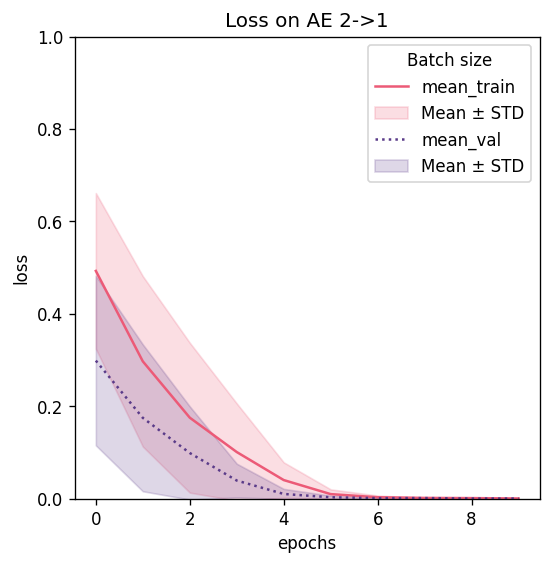

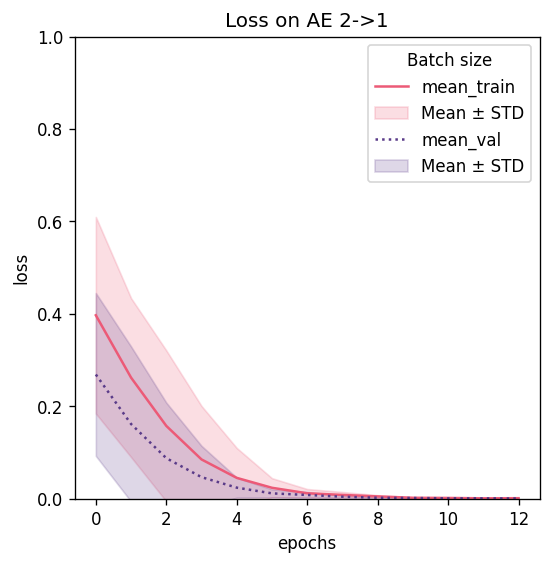

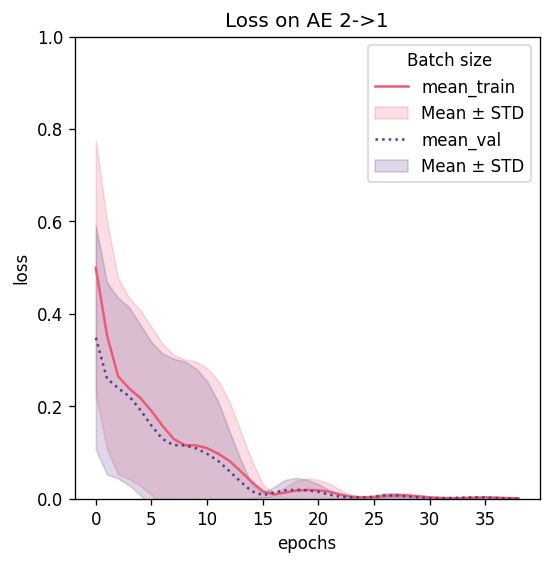

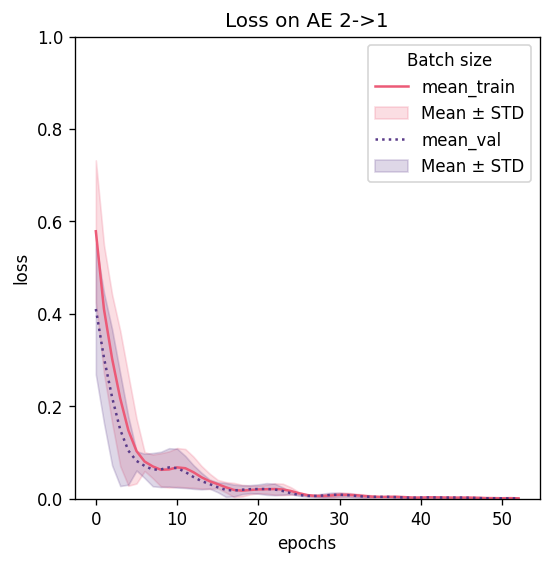

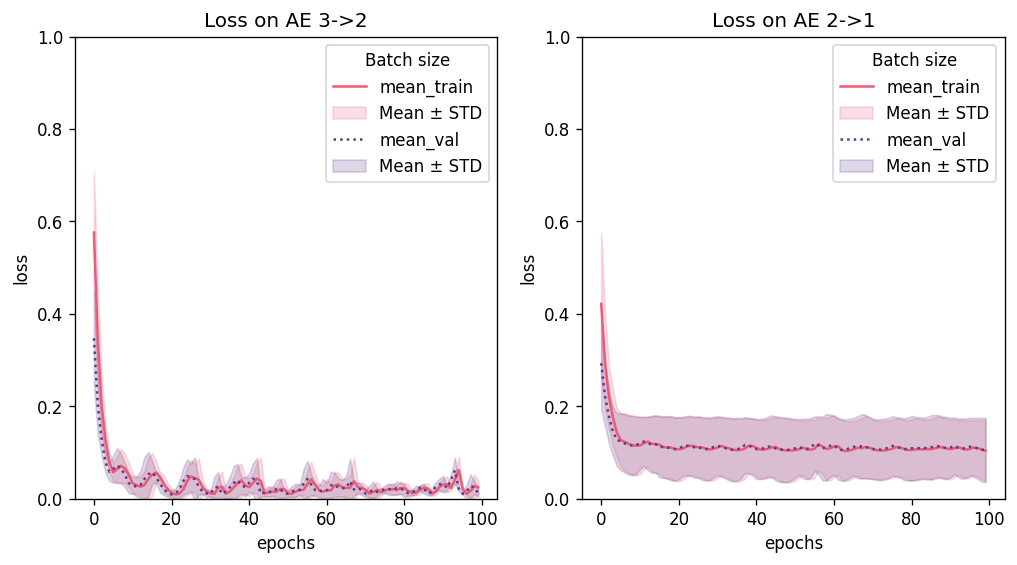

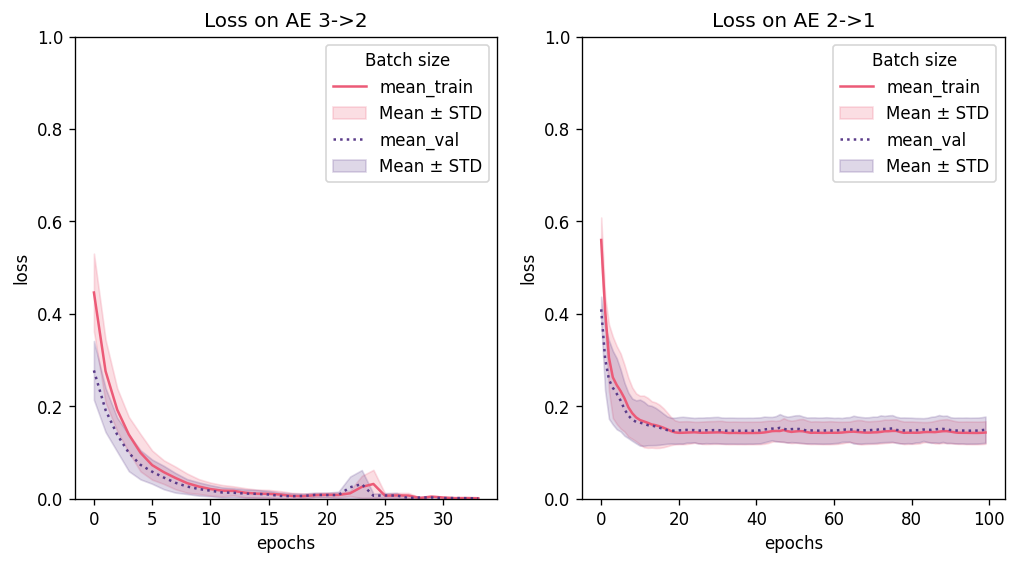

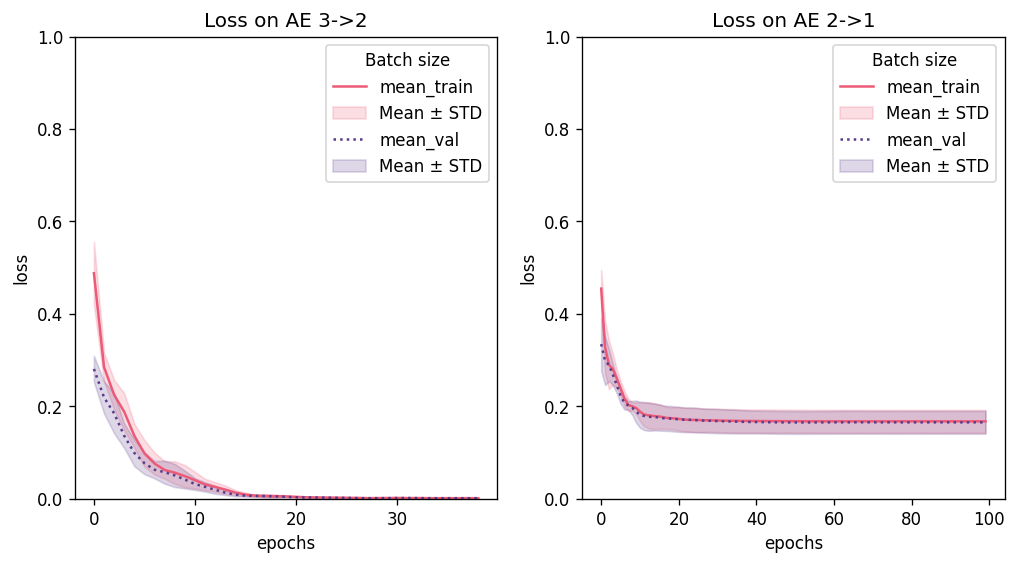

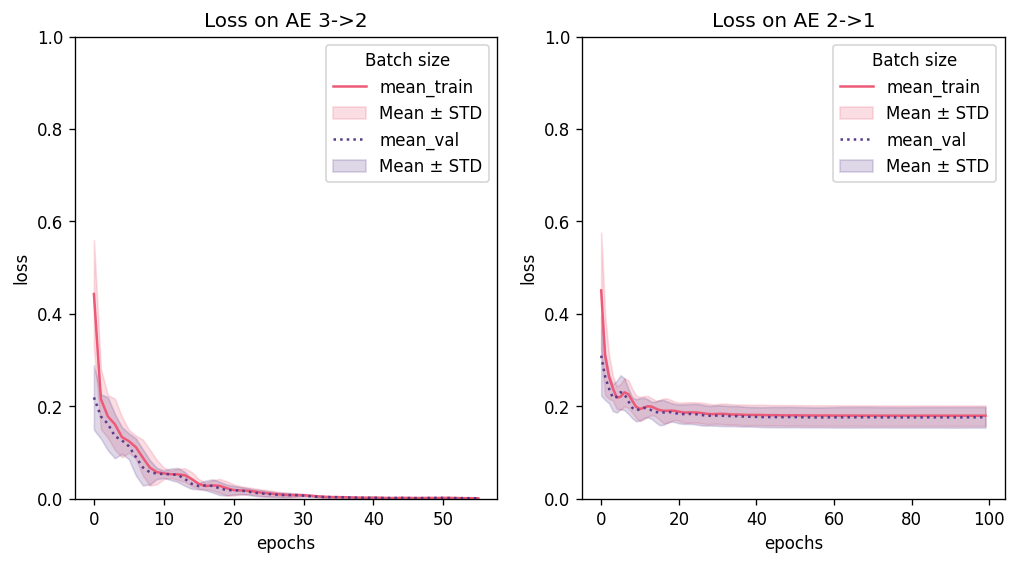

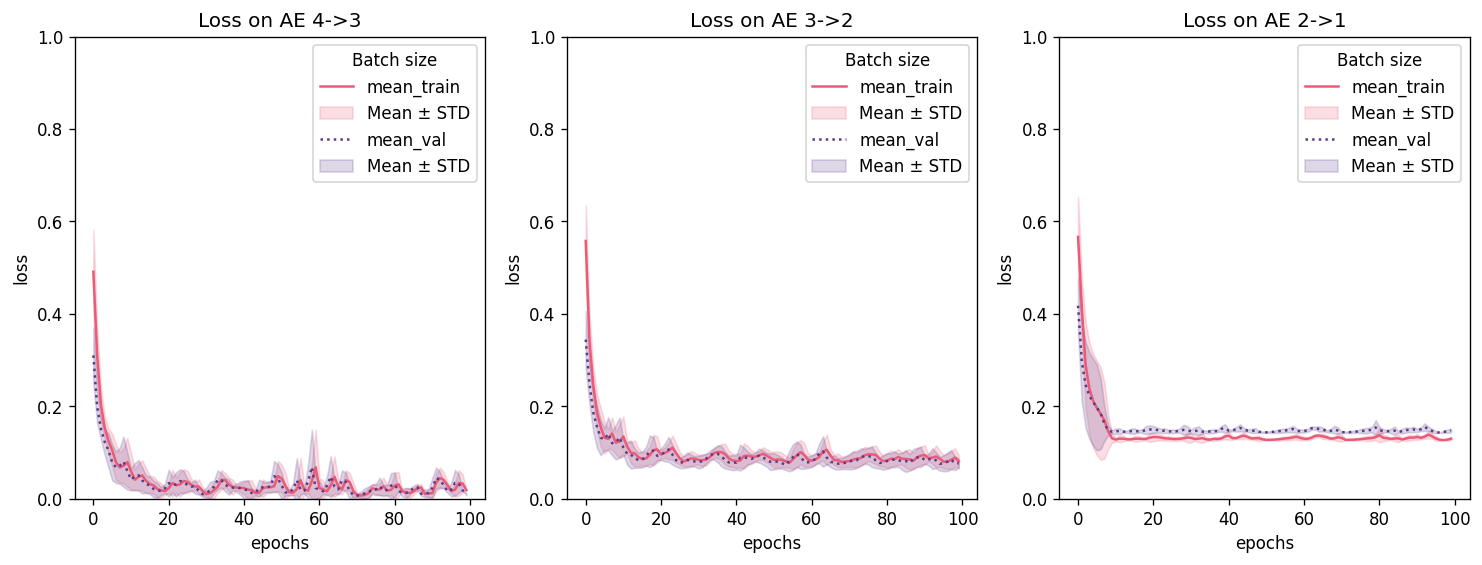

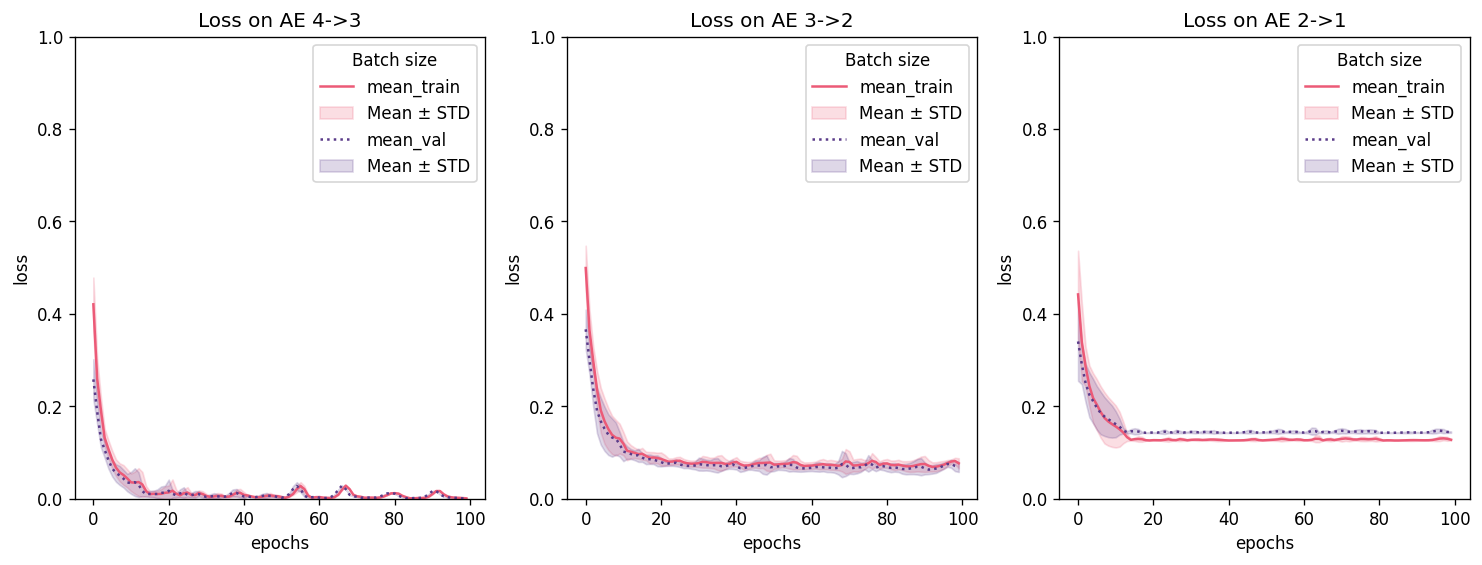

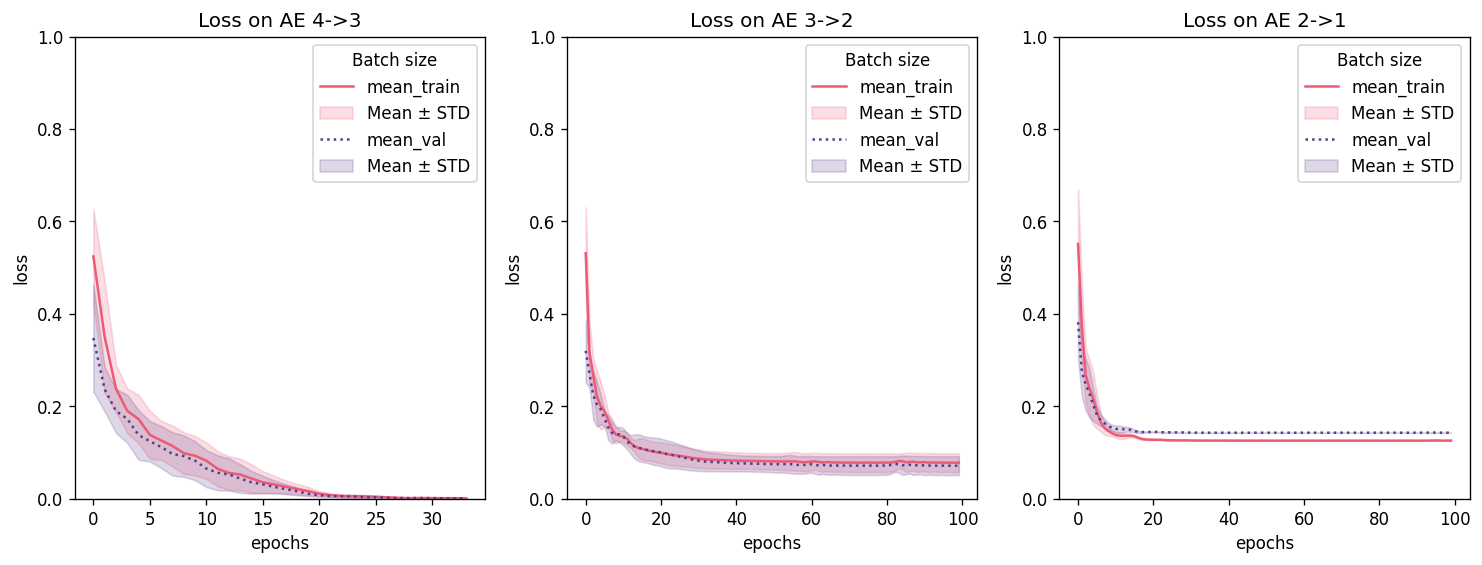

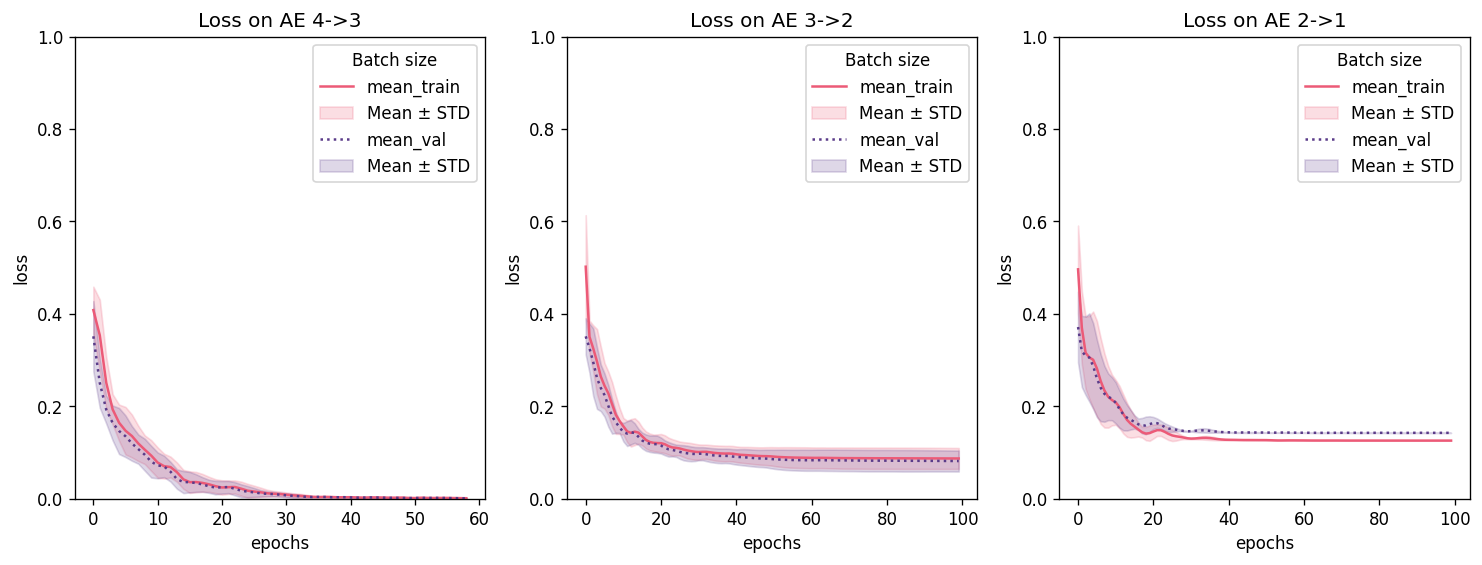

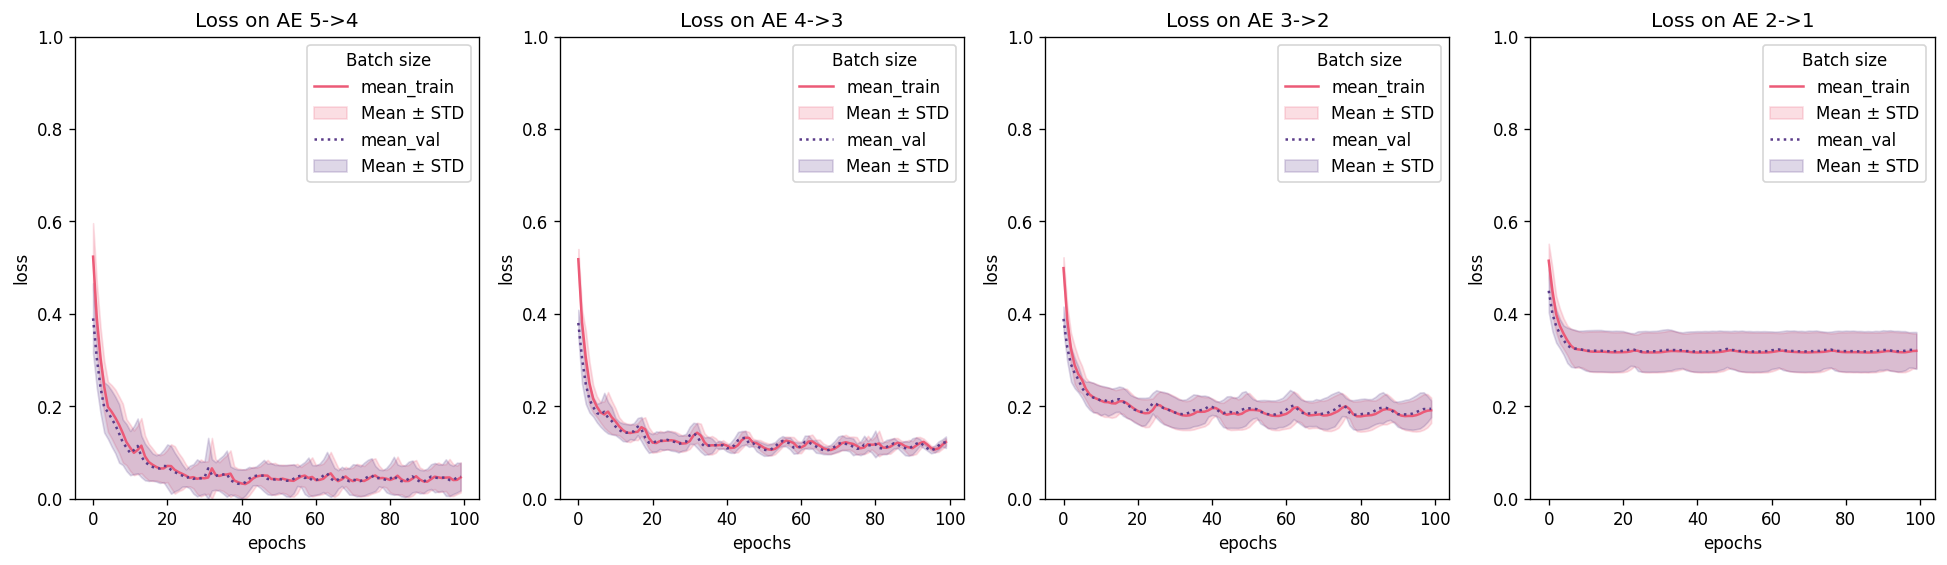

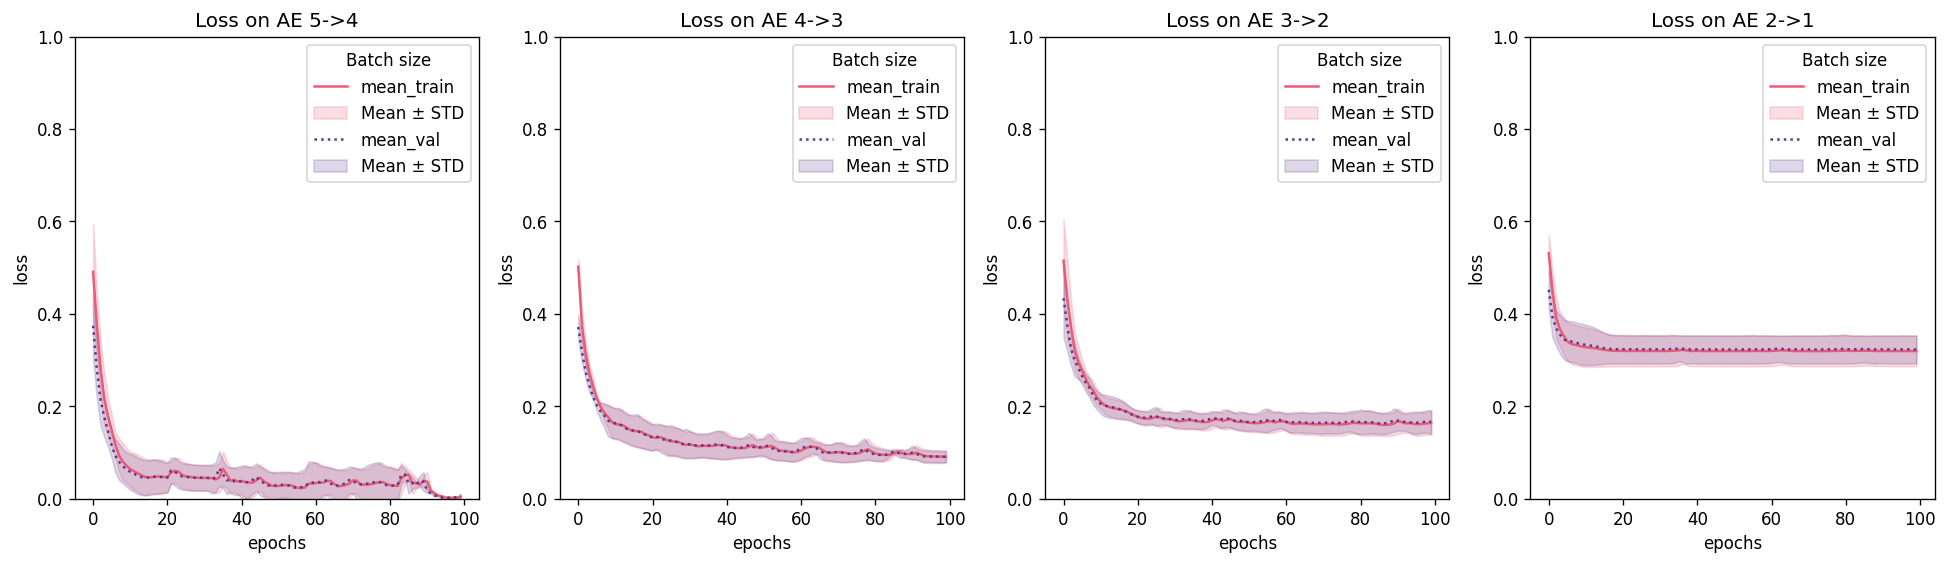

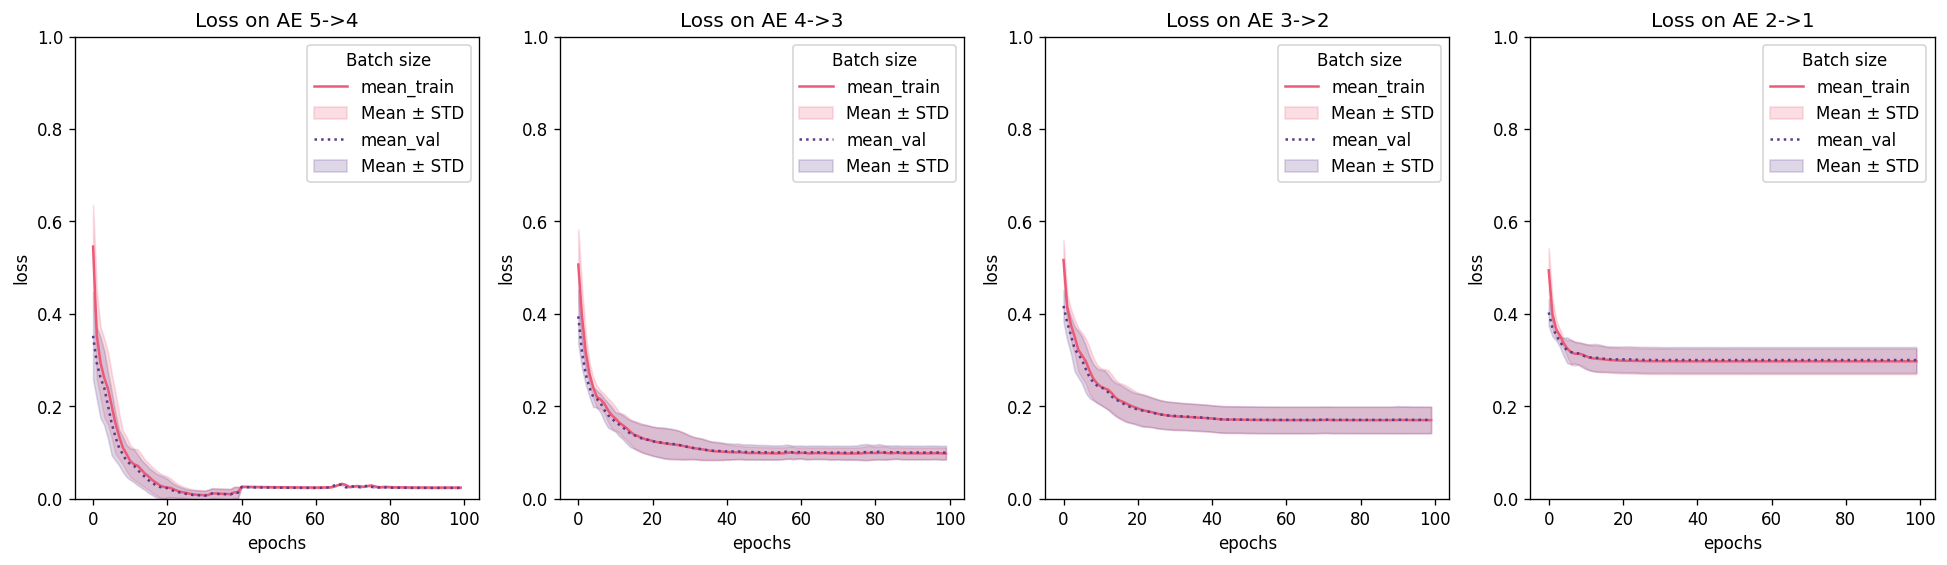

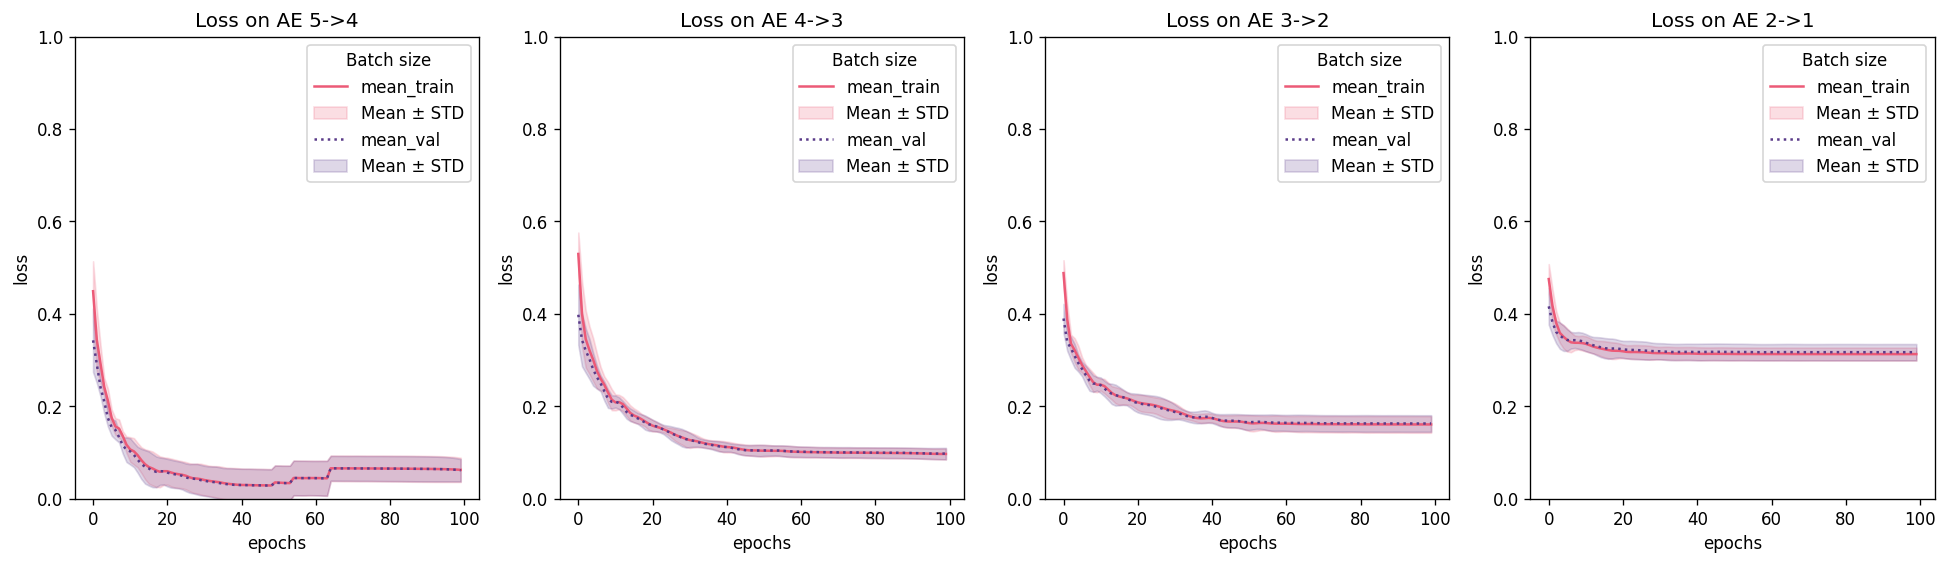

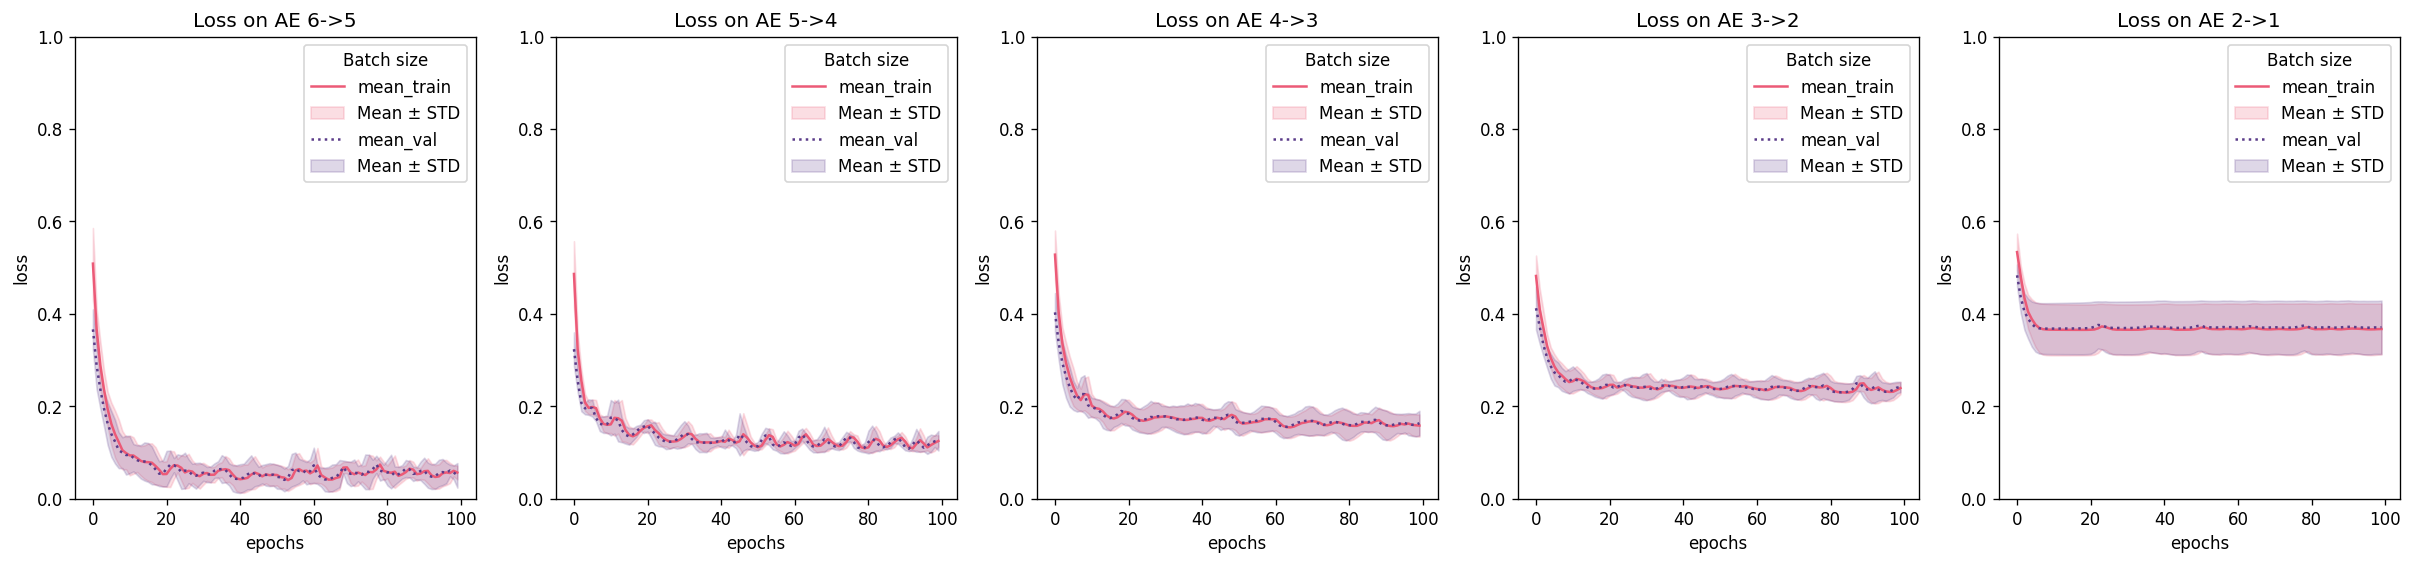

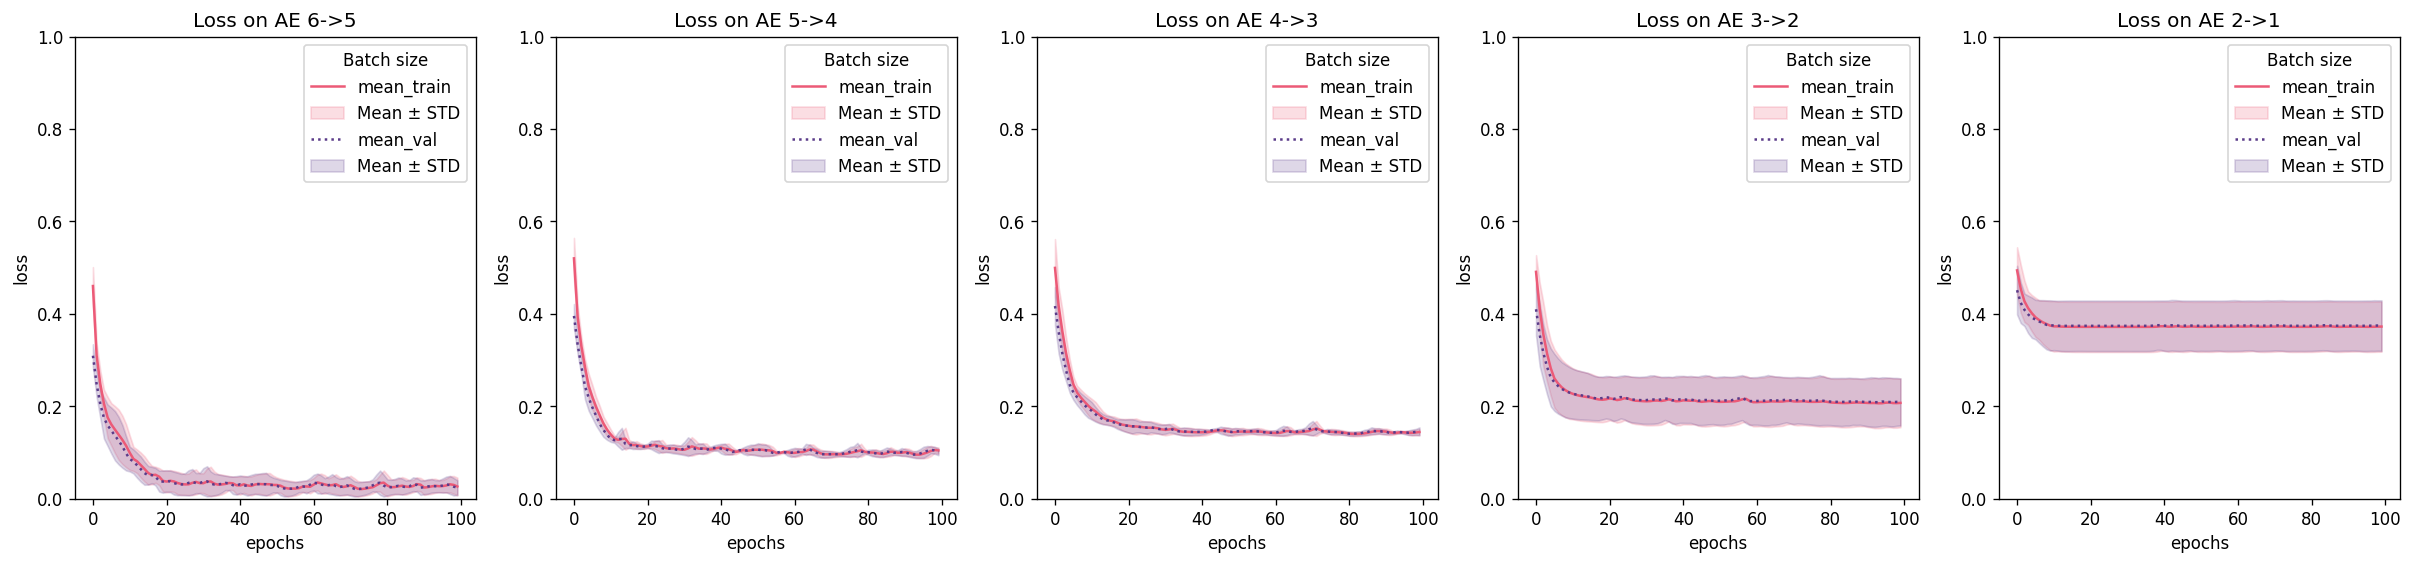

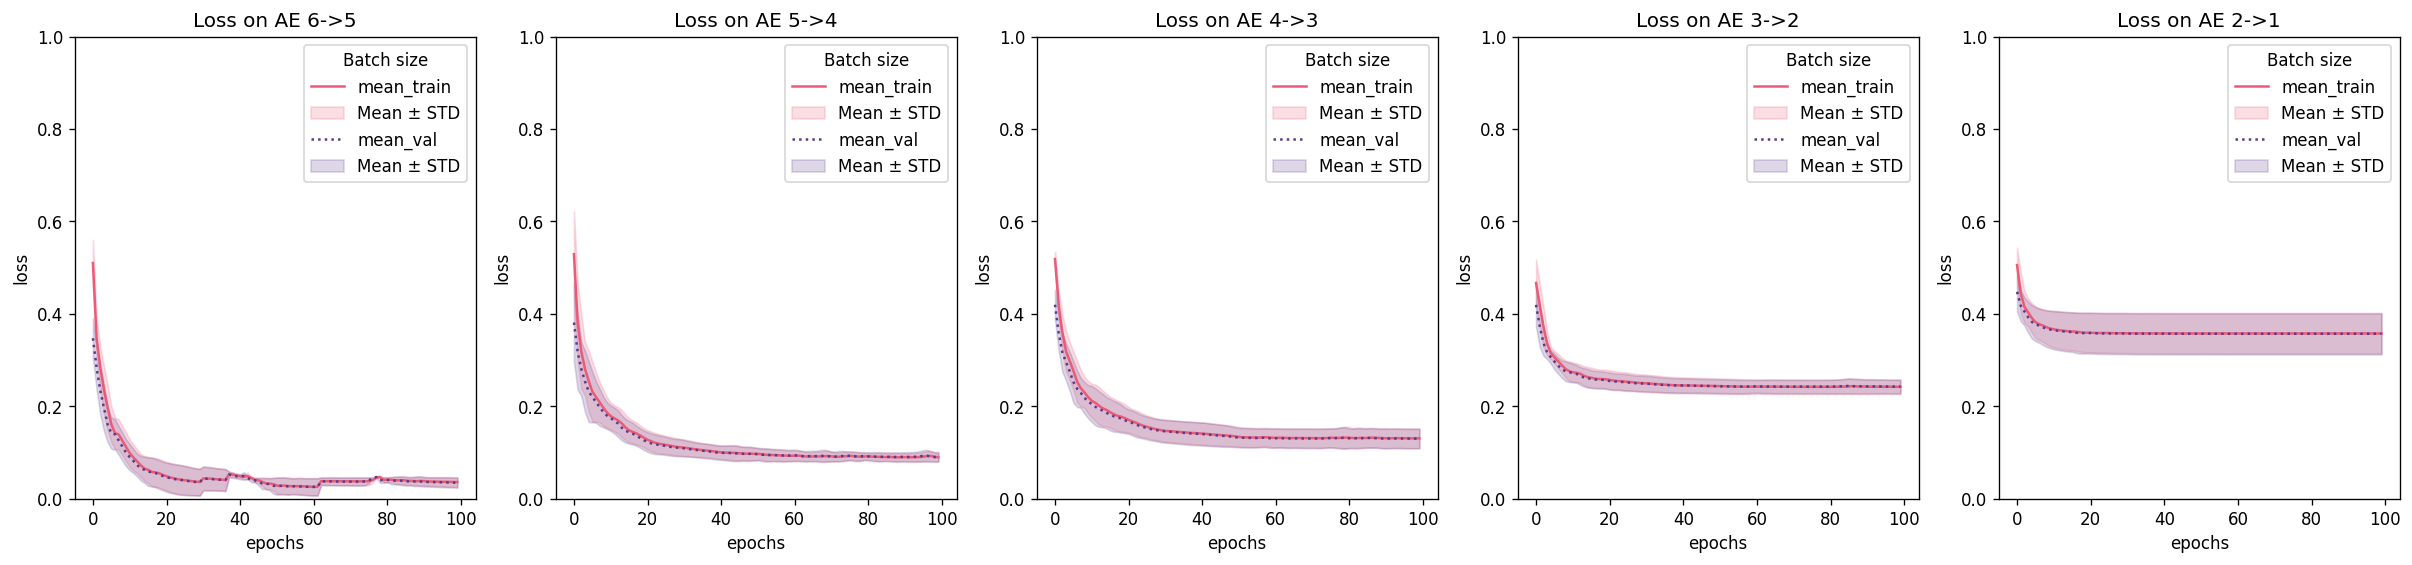

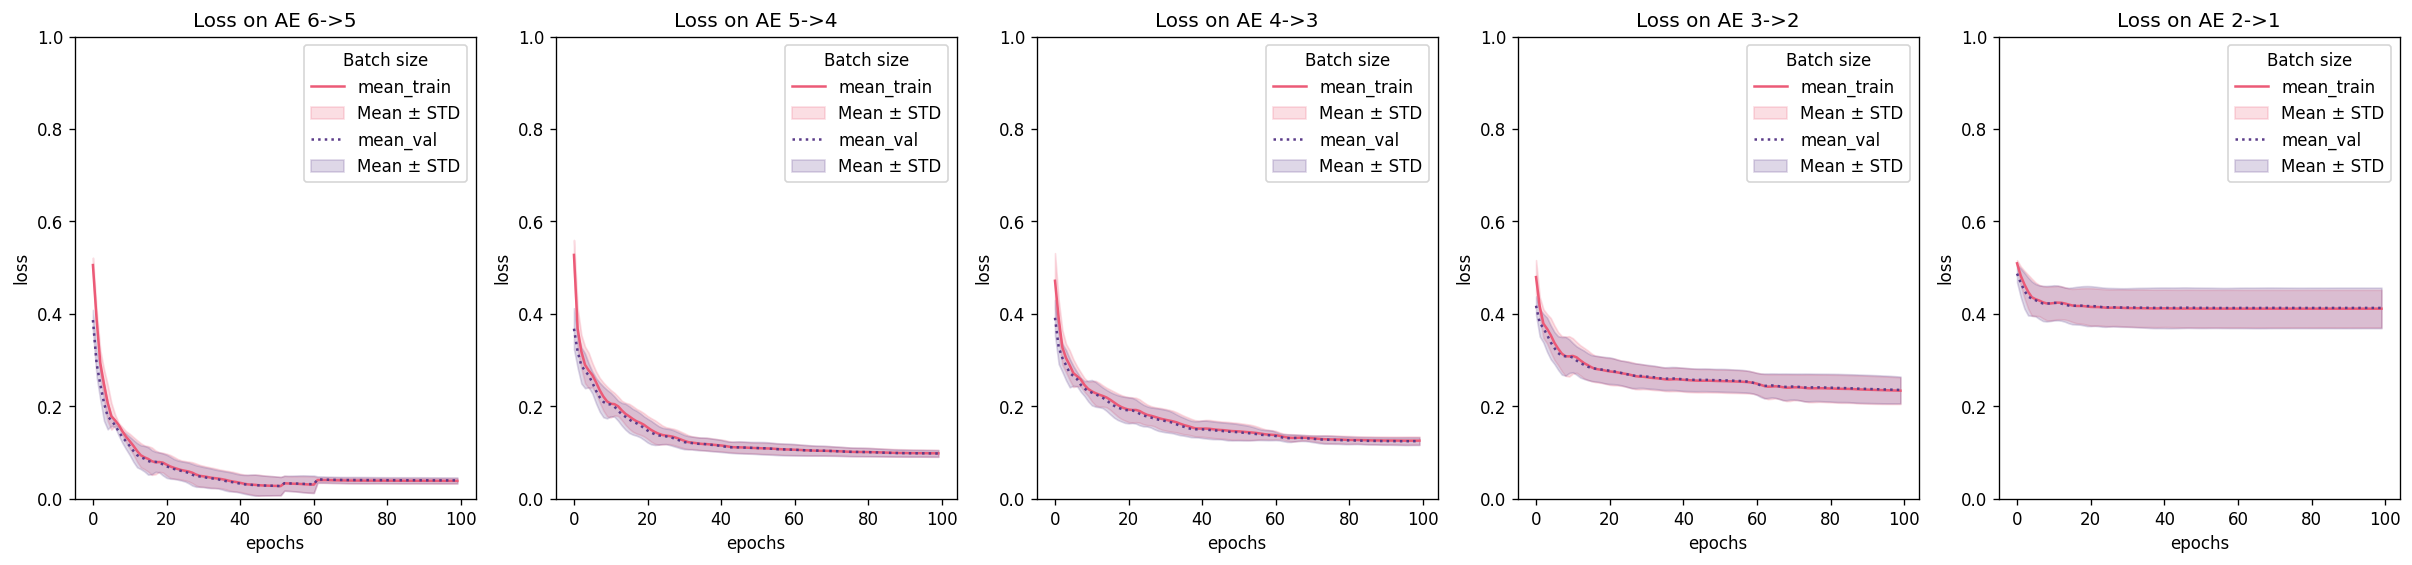

In [5]:
for n_qubit_autoencoder in range_qubit_autoencoder:
    r_train_batch_losses=[]
    r_val_batch_losses=[]
    r_batch_times=[]

    for batch_size in range_batches:
        for rep in range(repetition):
            print(f'repetition number: {rep}\n')
            n_trash_qubit = n_qubit_autoencoder-1
            train_batch_losses={}
            val_batch_losses={}
            batch_times={}
            img_folder=f'runs/run_{n_qubit_autoencoder}to{n_qubit_autoencoder-n_trash_qubit}'
            os.makedirs(img_folder,exist_ok=True)
            folder=img_folder+f'/{batch_size}'
            print(f"Running AE with {n_qubit_autoencoder} input qubit and {n_trash_qubit} trash qubit in batches of {batch_size}")


            dvc = qml.device('default.qubit', wires=n_qubit_autoencoder, shots=None)
            ae = Autoencoder_iterative(n_qubit_autoencoder,n_trash_qubit,dvc,arch='c11')
            start_time = time.time()
            ae.train(X,opt,epochs,batch_size,val_split=.33)
            end_time = time.time()


            os.makedirs(folder+f'/loss_train',exist_ok=True)
            os.makedirs(folder+f'/loss_val',exist_ok=True)

            train_loss,val_loss=ae.get_loss()
            train_batch_losses[batch_size]=train_loss
            val_batch_losses[batch_size]=val_loss
            batch_times[batch_size]=end_time-start_time
            weights=ae.best_params()

            for k,v in train_loss.items():
                np.save(folder+f'/loss_train/loss_train_{n_qubit_autoencoder-k}to{n_qubit_autoencoder-k-1}_{rep}',np.array(v))            
                np.save(folder+f'/loss_val/loss_val_{n_qubit_autoencoder-k}to{n_qubit_autoencoder-k-1}_{rep}',np.array(v))            
            np.save(folder+f'/weights_{rep}',np.array(weights))
            
            
            r_train_batch_losses.append(train_batch_losses)
            r_val_batch_losses.append(val_batch_losses)
            r_batch_times.append(batch_times)

    # Min loss
    # min_val_found= [(k, f, min(c)) for k, a_dict in val_batch_losses.items() for f, c in a_dict.items()]
    # min_train_found= [(k, f, min(c)) for k, a_dict in train_batch_losses.items() for f, c in a_dict.items()]
    
    min_loss,rank =get_min_loss_fid(X,n_qubit_autoencoder,n_trash_qubit)


    train_plot_dict=get_plot_dict(r_train_batch_losses,n_trash_qubit,range_batches)
    val_plot_dict=get_plot_dict(r_val_batch_losses,n_trash_qubit,range_batches)
    # Figure
    for b in range_batches:
        plt.figure(figsize=(5*n_trash_qubit,5),dpi=120)

        for k in range(n_trash_qubit):
            axs=plt.subplot(1,n_trash_qubit,k+1)
            sns.set_palette(custom_palette)
            avg, std =avg_and_std(train_plot_dict[b][k])
            sns.lineplot(x=range(len(avg)),y=avg,ax=axs,label=f'mean_train',color='#EC5A77')
            plt.fill_between(range(len(avg)), avg - std, avg + std, alpha=0.2, color='#EC5A77', label='Mean ± STD')
            avg, std =avg_and_std(val_plot_dict[b][k])
            sns.lineplot(x=range(len(avg)),y=avg,ax=axs,label=f'mean_val',color='#5A3B89',linestyle=':')
            plt.fill_between(range(len(avg)), avg - std, avg + std, alpha=0.2,color='#5A3B89', label='Mean ± STD')
            axs.legend(title='Batch size')
            plt.ylim((0,1))

            plt.xlabel('epochs')
            plt.ylabel('loss')
            plt.title(f'Loss on AE {n_qubit_autoencoder-k}->{n_qubit_autoencoder-k-1}')
            plt.savefig(img_folder+f'/{n_qubit_autoencoder}_{n_qubit_autoencoder-n_trash_qubit}_batch{b}')

        plt.plot()



    # axs.hlines(min_loss,0,epochs,color='#773344',linestyle='--')
    # axs.text(x=epochs//3*2, y=min_loss+0.05, fontsize='medium', s=f'Min loss', color='#773344', ha='right', va='center')
    # Info file 
    mean_time={b:np.mean([list(a.values()) for a in r_batch_times ]) for b in range_batches}

    with open(img_folder+f'/info.txt','a') as file:
        file.write(f'RUN INFORMATION\nInput qubits={n_qubit_autoencoder}\nTrash qubit={n_trash_qubit}\nSeed={seed}\nOptimizer=AdamOptimizer(stepsize={opt.stepsize})\nRepetition={repetition}\nEpochs={epochs}\nBatch sizes={range_batches}\nMin fidelity loss={min_loss}\nDensity matrix rank={rank}\nExec (training) time=\n{''.join([f'\t\t\t\t{a}\t:\t{b}\n' for a, b in mean_time .items()])}')
                    # Min val loss found =\n{''.join([f'\t\t\t{n_qubit_autoencoder-a[1]}->{n_qubit_autoencoder-a[1]-1}\t{a[0]}\t:\t{a[2]}\n'  for a in min_val_found])}\n/
